Data Science Semester project
@Authour: Ben Funk

Just as a disclaimer, I was running all of my code on either an apple M2 max 12 core CPU and 38 core GPU 64 GB ram or a Nvidia 3070 intel i7 10700k with 96 GB ram, and the code took a couple hours on both of my setups. This is a very intensive run so expect it to take a while. I have tried to take out the most computationally intensive parts to make it run faster though.

This was iteration one of getting the code to work and then V2.0 was made to streamline the code and make running it easier.

the dataset is taken from: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/ or https://www.kaggle.com/code/skylarhew/python-spotify-matrix


In [2]:
# Standard DS imports
import pandas as pd
import numpy as np
from sklearn import neighbors
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
import ast
from sklearn import svm

# All pytorch dependencies
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split



# all tensorflow dependencies
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping
from keras import metrics

In [3]:
# Loading data from csv
dataFrame = pd.read_csv('./tracks.csv')
dataFrame.head()


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [4]:
column_names = dataFrame.columns
print(column_names)

Index(['id', 'name', 'popularity', 'duration_ms', 'explicit', 'artists',
       'id_artists', 'release_date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')


In [5]:

# variable I will try to predict: popularity

Cutoff = 40
Cutoffp = Cutoff / 100

dataFrame['release_date'] = pd.to_datetime(dataFrame['release_date'], errors='coerce').dt.year

# # Convert the string representation of list to actual list
# dataFrame['id_artists'] = dataFrame['id_artists'].apply(ast.literal_eval)
# dataFrame['artists'] = dataFrame['artists'].apply(ast.literal_eval)
# 
# # Flatten the lists and get a list of all unique artist ids
# unique_ids = pd.unique([item for sublist in dataFrame['id_artists'].tolist() for item in sublist])
# 
# # Create a mapping of ids to unique numbers
# id_to_num = {id:i for i, id in tqdm(enumerate(unique_ids))}
# 
# # Apply the mapping to the 'id_artists' column
# dataFrame['id_number'] = dataFrame['id_artists'].apply(lambda x: [id_to_num[i] for i in x])

dataFrame = dataFrame.drop(columns=['id', 'name', 'artists', 'id_artists'])

<Axes: >

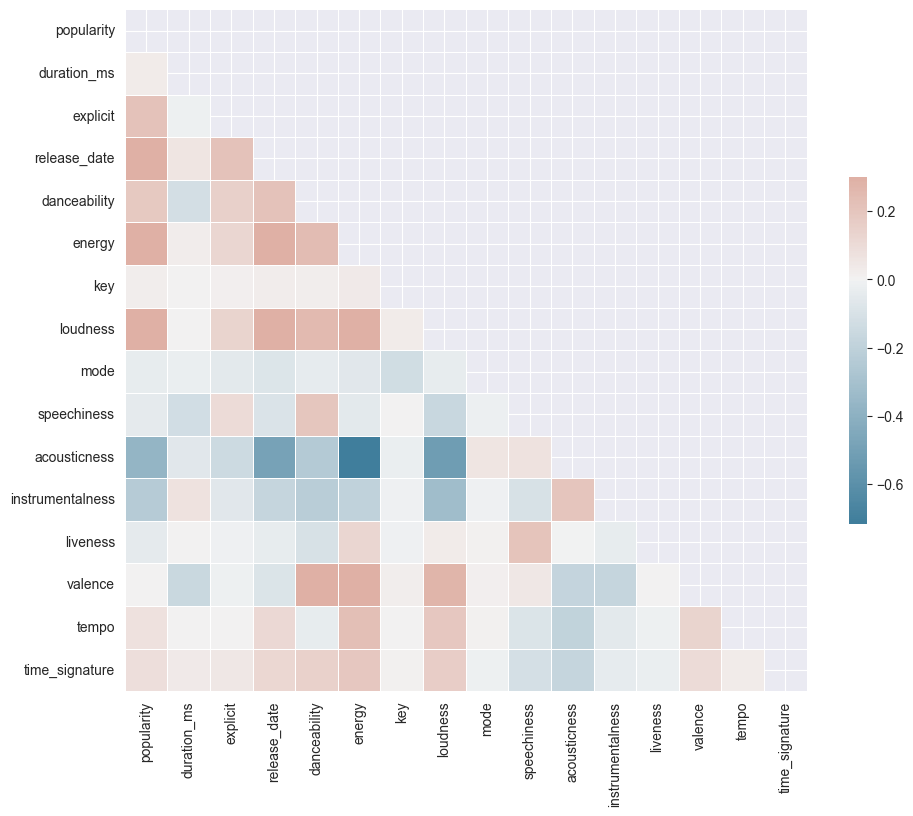

In [6]:
# Calculate correlation matrix
corr_matrix = dataFrame.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True,)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Label to integer mapping: {'acoustic': 0, 'afrobeat': 1, 'alt-rock': 2, 'alternative': 3, 'ambient': 4, 'anime': 5, 'black-metal': 6, 'bluegrass': 7, 'blues': 8, 'brazil': 9, 'breakbeat': 10, 'british': 11, 'cantopop': 12, 'chicago-house': 13, 'children': 14, 'chill': 15, 'classical': 16, 'club': 17, 'comedy': 18, 'country': 19, 'dance': 20, 'dancehall': 21, 'death-metal': 22, 'deep-house': 23, 'detroit-techno': 24, 'disco': 25, 'disney': 26, 'drum-and-bass': 27, 'dub': 28, 'dubstep': 29, 'edm': 30, 'electro': 31, 'electronic': 32, 'emo': 33, 'folk': 34, 'forro': 35, 'french': 36, 'funk': 37, 'garage': 38, 'german': 39, 'gospel': 40, 'goth': 41, 'grindcore': 42, 'groove': 43, 'grunge': 44, 'guitar': 45, 'happy': 46, 'hard-rock': 47, 'hardcore': 48, 'hardstyle': 49, 'heavy-metal': 50, 'hip-hop': 51, 'honky-tonk': 52, 'house': 53, 'idm': 54, 'indian': 55, 'indie': 56, 'indie-pop': 57, 'industrial': 58, 'iranian': 59, 'j-dance': 60, 'j-idol': 61, 'j-pop': 62, 'j-rock': 63, 'jazz': 64, 'k-pop': 65, 'kids': 66, 'latin': 67, 'latino': 68, 'malay': 69, 'mandopop': 70, 'metal': 71, 'metalcore': 72, 'minimal-techno': 73, 'mpb': 74, 'new-age': 75, 'opera': 76, 'pagode': 77, 'party': 78, 'piano': 79, 'pop': 80, 'pop-film': 81, 'power-pop': 82, 'progressive-house': 83, 'psych-rock': 84, 'punk': 85, 'punk-rock': 86, 'r-n-b': 87, 'reggae': 88, 'reggaeton': 89, 'rock': 90, 'rock-n-roll': 91, 'rockabilly': 92, 'romance': 93, 'sad': 94, 'salsa': 95, 'samba': 96, 'sertanejo': 97, 'show-tunes': 98, 'singer-songwriter': 99, 'ska': 100, 'sleep': 101, 'songwriter': 102, 'soul': 103, 'spanish': 104, 'study': 105, 'swedish': 106, 'synth-pop': 107, 'tango': 108, 'techno': 109, 'trance': 110, 'trip-hop': 111, 'turkish': 112, 'world-music': 113}

This is a lot to go through but basically it is assigning each genre a number so that I now have a quantitative variable instead of a qualitative one. this allows for a neural net to run on the data.

In [7]:
inputs = [ 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness','instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit'] # 'track_genre_encoded',
target = ['popularity']

In [8]:
xtrain, xtest, ytrain, ytest = train_test_split(dataFrame[inputs], dataFrame[target], test_size=0.2, random_state=42)

In [9]:
# Assuming y_train is your training labels
positive_class_proportion = np.mean(ytrain)

print(f"The AUPRC baseline is: {positive_class_proportion}")

The AUPRC baseline is: 27.571804481641124


This means that if my model is guessing it should have a score of 0.24 or 24% as the I am working with an unbalanced dataset. It focuses on the trade-off between precision and recall, and the AUPRC (Area Under the Precision-Recall Curve) is  useful for evaluating imbalanced dataset models... like what I have. It provides a measure of how well the model can increase its prediction accuracy on the positive class without incurring too many false positive errors.

In [10]:
kvals = range(1,100,1)
train_score = []
test_score = []
test_scores = {}

for k in tqdm(kvals):
    model = neighbors.KNeighborsRegressor(k)
    model.fit(xtrain,ytrain)

    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)

    train_score.append(accuracy_score(ytrain, y_train_pred))
    val = accuracy_score(ytest, y_test_pred)
    test_score.append(val)
    test_scores[k] = val  # Store the score for each k-value in the dictionary

plt.plot(kvals, train_score, 'r-s', label='Train')
plt.plot(kvals, test_score, 'b-o', label='Test')
plt.legend()
plt.show()

# Print out the k value that gave the highest test score
print(f"The best k value is : {max(test_scores, key=test_scores.get)}")

  1%|          | 1/99 [00:17<28:40, 17.56s/it]


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

this does fine on the training set but leaves much to be desired on the testing set. for this project any f1 score over .5 will be a good model

In [ ]:
# plt.plot(kvals, train_score, 'r-s', label='Train')
# plt.plot(kvals, test_score, 'b-o', label='Test')
# plt.xlabel('Kernel Value')
# plt.ylabel('Accuracy')
# plt.title('K-Nearest Neighbors Regression Model Training and Evaluation')
# plt.legend()
# plt.show()

In [ ]:
# fitting model
model = neighbors.KNeighborsRegressor(15)
model.fit(xtrain, ytrain)

# creating predictions
y_train_scores = model.predict(xtrain)
y_test_scores = model.predict(xtest)

# Apply same threshold to train predictions
y_train_pred = (y_train_scores > Cutoffp).astype(int)
y_test_pred = (y_test_scores > Cutoffp).astype(int)

ytrain = (ytrain > Cutoffp).astype(int)
ytest = (ytest > Cutoffp).astype(int)

# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(ytrain, y_train_pred)
precision_test, recall_test, _ = precision_recall_curve(ytest, y_test_pred)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}\n")

# Calculate F1 Score
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test} \n")

# Calculate accuracy, precision and recall for training set
accuracy_train = accuracy_score(ytrain, y_train_pred)
precision_train = precision_score(ytrain, y_train_pred, average='macro')
recall_train = recall_score(ytrain, y_train_pred, average='macro')

# Calculate accuracy, precision and recall for test set
accuracy_test = accuracy_score(ytest, y_test_pred)
precision_test = precision_score(ytest, y_test_pred, average='macro')
recall_test = recall_score(ytest, y_test_pred, average='macro')

print(f"Accuracy on Training set: {accuracy_train}")
print(f"Accuracy on Testing set: {accuracy_test}\n")

print(f"Recall on Training set: {recall_train}")
print(f"Recall on Testing set: {recall_test}\n")

print(f"Precision on Training set: {precision_train}")
print(f"Precision on Testing set: {precision_test}\n")

# Calculate confusion matrix for training set and test set
cm_train = confusion_matrix(ytrain, y_train_pred)
cm_test = confusion_matrix(ytest, y_test_pred)

print(f"Confusion Matrix on Training set: \n{cm_train}")
print(f"Confusion Matrix on Testing set: \n{cm_test}")

In [ ]:

ytrain.loc[ytrain['popularity'] > Cutoff, 'popularity'] = 1
ytest.loc[ytest['popularity'] > Cutoff, 'popularity'] = 1

model = neighbors.KNeighborsClassifier(55) # also try 4
model.fit(xtrain, ytrain.values.ravel())
y_train_scores = model.predict_proba(xtrain)[:, 1]
y_test_scores = model.predict_proba(xtest)[:, 1]

#Apply a same threshold to train predictions
y_train_pred = (y_train_scores > Cutoffp).astype(int)
y_test_pred = (y_test_scores > Cutoffp).astype(int)

# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(ytrain, y_train_pred)
precision_test, recall_test, _ = precision_recall_curve(ytest, y_test_pred)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}\n")

# Calculate F1 Score
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test} \n")

# Calculate accuracy, precision and recall for training set
accuracy_train = accuracy_score(ytrain, y_train_pred)
precision_train = precision_score(ytrain, y_train_pred, average='macro')
recall_train = recall_score(ytrain, y_train_pred, average='macro')

# Calculate accuracy, precision and recall for test set
accuracy_test = accuracy_score(ytest, y_test_pred)
precision_test = precision_score(ytest, y_test_pred, average='macro')
recall_test = recall_score(ytest, y_test_pred, average='macro')

print(f"\nAccuracy on Training set: {accuracy_train}")
print(f"Accuracy on Testing set: {accuracy_test}\n")

print(f"Recall on Training set: {recall_train}")
print(f"Recall on Testing set: {recall_test}\n")

print(f"Precision on Training set: {precision_train}")
print(f"Precision on Testing set: {precision_test}\n")

# Calculate confusion matrix for training set and test set
cm_train = confusion_matrix(ytrain, y_train_pred)
cm_test = confusion_matrix(ytest, y_test_pred)

print(f"Confusion Matrix on Training set: \n{cm_train}")
print(f"Confusion Matrix on Testing set: \n{cm_test}")

In [28]:
# Data importing
dataFrame = pd.read_csv('./tracks.csv')
dataFrame['popularity_flag'] = 0
dataFrame.loc[dataFrame['popularity'] >Cutoff, 'popularity_flag'] = 1

# Drop the columns
dataFrame = dataFrame.drop(columns=['id', 'name', 'artists', 'id_artists', 'release_date', 'popularity'])

# Split into features and target
X = dataFrame.drop(columns=['popularity_flag'])
y = dataFrame['popularity_flag']

In [29]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from torch.utils.data import WeightedRandomSampler
# Handle missing values - filling with 0 as an example
X_filled = X.fillna(0)

# makes sure its all one type
X_filled = X_filled.astype('float32')

# Assuming X_filled and y are your features and target variable respectively
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_filled, y)

# Convert the resampled data back to Pandas DataFrame and Series, if necessary
X_resampled_df = pd.DataFrame(X_resampled, columns=X_filled.columns)
y_resampled_series = pd.Series(y_resampled)

# Now convert the balanced dataset to PyTorch tensors
X_tensor = torch.tensor(X_resampled_df.values, dtype=torch.float32)
y_tensor = torch.tensor(y_resampled_series.values, dtype=torch.float32).unsqueeze(1)

# Create TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader without using a sampler, as the dataset is now balanced
train_loader = DataLoader(train_dataset, batch_size=200, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=200, pin_memory=True)

In [23]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [26]:
# Model definition
class NeuralNetwork(nn.Module):
    def __init__(self, input_shape):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_shape, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ELU(),
            nn.Linear(32, 16),
            nn.ELU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [27]:
# Loss Functions
# Model, loss function, and optimizer
model = NeuralNetwork(X_tensor.shape[1]).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

# Training and evaluation functions
def train(model, device, train_loader, optimizer, loss_fn):
    model.train()
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

def evaluate(model, device, loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            predictions.extend(output.round().cpu().numpy())
            actuals.extend(y.cpu().numpy())
    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()
    return accuracy_score(actuals, predictions), precision_score(actuals, predictions), recall_score(actuals, predictions), f1_score(actuals, predictions)

# Training loop
for epoch in range(10):
    train(model, device, train_loader, optimizer, loss_fn)
    accuracy, precision, recall, f1 = evaluate(model, device, test_loader)
    print(f'Epoch: {epoch+1}, Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')


/Users/benfunk/DataspellProjects/RandomProjects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 1, Accuracy: 0.50, Precision: 0.00, Recall: 0.00, F1: 0.00


/Users/benfunk/DataspellProjects/RandomProjects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2, Accuracy: 0.50, Precision: 0.00, Recall: 0.00, F1: 0.00


/Users/benfunk/DataspellProjects/RandomProjects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3, Accuracy: 0.50, Precision: 0.00, Recall: 0.00, F1: 0.00


/Users/benfunk/DataspellProjects/RandomProjects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4, Accuracy: 0.50, Precision: 0.00, Recall: 0.00, F1: 0.00


/Users/benfunk/DataspellProjects/RandomProjects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5, Accuracy: 0.50, Precision: 0.00, Recall: 0.00, F1: 0.00


/Users/benfunk/DataspellProjects/RandomProjects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6, Accuracy: 0.50, Precision: 0.00, Recall: 0.00, F1: 0.00


/Users/benfunk/DataspellProjects/RandomProjects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7, Accuracy: 0.50, Precision: 0.00, Recall: 0.00, F1: 0.00


/Users/benfunk/DataspellProjects/RandomProjects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8, Accuracy: 0.50, Precision: 0.00, Recall: 0.00, F1: 0.00


/Users/benfunk/DataspellProjects/RandomProjects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 9, Accuracy: 0.50, Precision: 0.00, Recall: 0.00, F1: 0.00
Epoch: 10, Accuracy: 0.50, Precision: 0.00, Recall: 0.00, F1: 0.00


/Users/benfunk/DataspellProjects/RandomProjects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


All code below is from tensorflow, however, as I couldn't gpu accelerate it I am switching to pytorch since that will allow me to use the GPU

Epoch 1, Loss: 0.6918, Val Loss: 0.6934
Epoch 2, Loss: 0.6924, Val Loss: 0.6932
Epoch 3, Loss: 0.6927, Val Loss: 0.6931
Epoch 4, Loss: 0.6928, Val Loss: 0.6931
Epoch 5, Loss: 0.6929, Val Loss: 0.6931
Epoch 6, Loss: 0.6930, Val Loss: 0.6931
Early stopping triggered
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/Users/benfunk/DataspellProjects/RandomProjects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


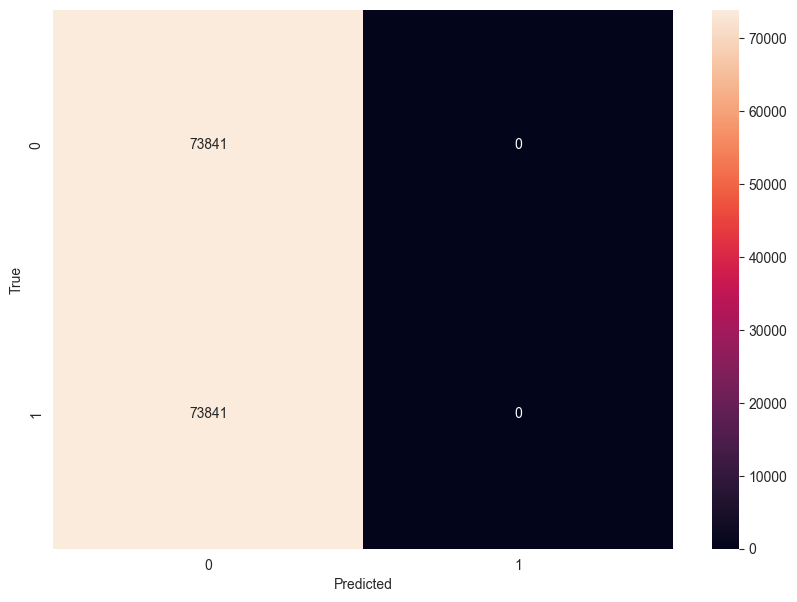

In [36]:
from sklearn.utils import resample
# Data importing
dataFrame = pd.read_csv('./tracks.csv')
dataFrame['popularity_flag'] = 0
dataFrame.loc[dataFrame['popularity'] >Cutoff, 'popularity_flag'] = 1

# Drop the columns
dataFrame = dataFrame.drop(columns=['id', 'name', 'artists', 'id_artists', 'release_date', 'popularity'])

# Separate the majority and minority classes
majority_class = dataFrame[dataFrame['popularity_flag'] == 0]
minority_class = dataFrame[dataFrame['popularity_flag'] == 1]

# Split the minority class into two halves for training and testing
minority_class_train, minority_class_test = train_test_split(minority_class, test_size=0.5, random_state=42)

# Undersample the majority class without replacement to match the size of the minority class train subset
majority_class_undersampled = resample(majority_class,
                                       replace=False,
                                       n_samples=len(minority_class_train),  # Match minority class train size
                                       random_state=42)  # Reproducible results

# Combine for training data
train_data = pd.concat([majority_class_undersampled, minority_class_train])

# For testing data, ensure it's balanced or as needed. Here, we're balancing it.
majority_class_for_test = resample(majority_class,
                                   replace=False,
                                   n_samples=len(minority_class_test),  # Match minority class test size
                                   random_state=42)
test_data = pd.concat([majority_class_for_test, minority_class_test])

# Shuffle datasets
train_data = train_data.sample(frac=1, random_state=42)
test_data = test_data.sample(frac=1, random_state=42)

# Split back into features and labels
x_train, y_train = train_data.drop(y.name, axis=1), train_data[y.name]
x_test, y_test = test_data.drop(y.name, axis=1), test_data[y.name]

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

import torch.nn as nn
import torch.optim as optim

class MyModel(nn.Module):
    def __init__(self, input_size):
        super(MyModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_shape, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 32),
            nn.ELU(),
            nn.Linear(32, 16),
            nn.ELU(),
            nn.Linear(16, 4),
            nn.ELU(),
            nn.Linear(4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.layers(x)

# Model instantiation
model = MyModel(input_size=x_train.shape[1])

# Using BCEWithLogitsLoss instead of BCELoss
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Splitting the original training data into training and validation sets
x_train_tensor, x_val_tensor, y_train_tensor, y_val_tensor = train_test_split(x_train_tensor, y_train_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

# Training loop with validation phase
num_epochs = 10
# Placeholder for the best validation loss
best_val_loss = float('inf')

# Early stopping patience; the number of epochs to continue after seeing an increase in validation loss
patience = 2
patience_counter = 0
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Val Loss: {val_loss / len(val_loader):.4f}')

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')  # Save your best model
        patience_counter = 0  # Reset counter
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Ensure the model is in evaluation mode
model.eval()

# Lists for storing predictions and actual labels
predictions, actuals = [], []

with torch.no_grad():  # No need to track gradients during evaluation
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = outputs.squeeze().round()  # Convert probabilities to binary predictions
        predictions.extend(predicted.numpy())
        actuals.extend(labels.numpy())

# Convert lists to arrays for metric calculation
predictions = np.array(predictions)
actuals = np.array(actuals)

# Calculate metrics
accuracy = accuracy_score(actuals, predictions)
precision = precision_score(actuals, predictions)
recall = recall_score(actuals, predictions)
f1 = f1_score(actuals, predictions)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Visualize the confusion matrix
cm = confusion_matrix(actuals, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [37]:

# Convert to tensor
X_tensor = tf.convert_to_tensor(X.values, dtype=tf.float32)
y_tensor = tf.convert_to_tensor(y.values, dtype=tf.float32)

# Calculate the index at which to split the dataset
train_size = int(0.8 * len(X))

# Manually slice the tensors for train/test sets
x_train = X_tensor[:train_size]
y_train = y_tensor[:train_size]
x_test = X_tensor[train_size:]
y_test = y_tensor[train_size:]


In [38]:
@keras.saving.register_keras_serializable()
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

@keras.saving.register_keras_serializable()
def rmse(y_true, y_pred):
    return tf.sqrt(mse_loss(y_true,y_pred))

@keras.saving.register_keras_serializable()
def r_squared(y_true, y_pred,):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

@keras.saving.register_keras_serializable()
def r_squared_loss(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return 1 - r2  # or you can return -r2 to minimize the negative value



def plot_results(history):
    epoch_num = np.arange(1, len(history.history['loss'])+1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_num, history.history['loss'], label='training_loss')
    plt.plot(epoch_num, history.history['val_loss'], label='test_loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epoch_num, history.history['accuracy'], label='training_accuracy')
    plt.plot(epoch_num, history.history['val_accuracy'], label='test_accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

In [39]:
input_shape = (x_train.shape[1],)

# Build model function
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [40]:

# Define a set of class weights to evaluate
class_weights_grid = [{0:1.0, 1:weight} for weight in np.linspace(1, 10, 10)]  # Drop the 100 down to 10 if you are running this on a weaker computer.

# Initial placeholders for the best weights and highest f1 score
best_class_weights = None
highest_f1 = 0

for class_weights in tqdm(class_weights_grid):

    #Build and compile model as before
    model = build_model(input_shape)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[metrics.BinaryAccuracy(name='accuracy'),
                           metrics.Precision(name='precision'),
                           metrics.Recall(name='recall'),
                           metrics.AUC(name='auc')])

    # Train model with current class weight
    model.fit(x_train,
              y_train,
              epochs=20,
              validation_split=0.1,
              batch_size=200,
              class_weight=class_weights,
              verbose=0) # Turn off output 

    # Evaluate F1 Score
    y_train_scores = model.predict(x_train).flatten()
    y_train_pred = (y_train_scores > Cutoffp).astype(int)
    f1 = f1_score(y_train, y_train_pred)

    if f1 > highest_f1:
        best_class_weights = class_weights
        highest_f1 = f1

# Output the best class weights
print("Best class weights: ", best_class_weights)
print("Best F1 score: ", highest_f1)

  0%|          | 0/10 [00:12<?, ?it/s]


KeyboardInterrupt: 

Now that I have found the best class weight I will use that to train the final model

In [42]:

# Class weights for cost-sensitive training
class_weights = {0: 1., 1: 9}  # You can fine-tune this based on your specific case
early_stopping = EarlyStopping(monitor='accuracy', patience=50, restore_best_weights=True)

with tf.device('/GPU:0'):
    # Regular model training
    model = build_model(input_shape)
    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=[metrics.BinaryAccuracy(name='accuracy'), 
                           metrics.Precision(name='precision'), 
                           metrics.Recall(name='recall'), 
                           metrics.AUC(name='auc')])
    
    model.fit(x_train, y_train, epochs=20,validation_split=0.1, batch_size=200, class_weight = class_weights)

    # Get model's predictions (as class labels using threshold of 0.5)
    y_train_scores = model.predict(x_train).flatten()
    y_test_scores = model.predict(x_test).flatten()
    y_train_pred = (y_train_scores > Cutoffp).astype(int)
    y_test_pred = (y_test_scores > Cutoffp).astype(int)

    print(f"Summarizing model performance:\n")

# Calculate F1 Score
f1_train = f1_score(ytrain, y_train_pred, average= 'macro')
f1_test = f1_score(ytest, y_test_pred, average= 'macro')

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test} \n")

# Calculate accuracy, precision and recall for training set
accuracy_train = accuracy_score(ytrain, y_train_pred)
precision_train = precision_score(ytrain, y_train_pred, average='macro')
recall_train = recall_score(ytrain, y_train_pred, average='macro')

# Calculate accuracy, precision and recall for test set
accuracy_test = accuracy_score(ytest, y_test_pred)
precision_test = precision_score(ytest, y_test_pred, average='macro')
recall_test = recall_score(ytest, y_test_pred, average='macro')

print(f"\nAccuracy on Training set: {accuracy_train}")
print(f"Accuracy on Testing set: {accuracy_test}\n")

print(f"Recall on Training set: {recall_train}")
print(f"Recall on Testing set: {recall_test}\n")

print(f"Precision on Training set: {precision_train}")
print(f"Precision on Testing set: {precision_test}\n")

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}\n")

# Calculate confusion matrix for training set and test set
cm_train = confusion_matrix(ytrain, y_train_pred)
cm_test = confusion_matrix(ytest, y_test_pred)

print(f"Confusion Matrix on Training set: \n{cm_train}")
print(f"Confusion Matrix on Testing set: \n{cm_test}")

Epoch 1/20
2113/2113 [==============================] - 2s 689us/step - loss: 758.6689 - accuracy: 0.3736 - precision: 0.2607 - recall: 0.7682 - auc: 0.5020 - val_loss: 290.3574 - val_accuracy: 0.6522 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/20
2113/2113 [==============================] - 1s 676us/step - loss: 341.6530 - accuracy: 0.3739 - precision: 0.2603 - recall: 0.7654 - auc: 0.5012 - val_loss: 149.4517 - val_accuracy: 0.3478 - val_precision: 0.3478 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/20
2113/2113 [==============================] - 1s 639us/step - loss: 232.4526 - accuracy: 0.3736 - precision: 0.2602 - recall: 0.7658 - auc: 0.5013 - val_loss: 35.7753 - val_accuracy: 0.3484 - val_precision: 0.3480 - val_recall: 1.0000 - val_auc: 0.5025
Epoch 4/20
2113/2113 [==============================] - 1s 656us/step - loss: 154.9228 - accuracy: 0.3776 - precision: 0.2616 - recall: 0.7659 - auc: 0.5042 - val_loss: 37.1023 - val_accuracy: 0.3496 -

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
#Data importing
dataFrame = pd.read_csv('./tracks.csv')
dataFrame['popularity_flag'] = 0
dataFrame.loc[dataFrame['popularity'] > Cutoff, 'popularity_flag'] = 1

# Drop the columns
dataFrame = dataFrame.drop(columns=['id', 'name', 'artists', 'id_artists', 'release_date'])

# Split into features and target
X = dataFrame.drop(columns=['popularity_flag'])
y = dataFrame['popularity_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Print the confusion matrix using Matplotlib
y_train_scores_dt = dt.predict_proba(X_train)[:, 1]
y_test_scores_dt = dt.predict_proba(X_test)[:, 1]
# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores_dt)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores_dt)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}\n")

# Calculate F1 Score
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test} \n")

# Calculate accuracy, precision and recall for training set
accuracy_train = accuracy_score(ytrain, y_train_pred)
precision_train = precision_score(ytrain, y_train_pred, average='macro')
recall_train = recall_score(ytrain, y_train_pred, average='macro')

# Calculate accuracy, precision and recall for test set
accuracy_test = accuracy_score(ytest, y_test_pred)
precision_test = precision_score(ytest, y_test_pred, average='macro')
recall_test = recall_score(ytest, y_test_pred, average='macro')

print(f"\nAccuracy on Training set: {accuracy_train}")
print(f"Accuracy on Testing set: {accuracy_test}\n")

print(f"Recall on Training set: {recall_train}")
print(f"Recall on Testing set: {recall_test}\n")

print(f"Precision on Training set: {precision_train}")
print(f"Precision on Testing set: {precision_test}\n")

# Calculate confusion matrix for training set and test set
cm_train = confusion_matrix(ytrain, y_train_pred)
cm_test = confusion_matrix(ytest, y_test_pred)

print(f"Confusion Matrix on Training set: \n{cm_train}")
print(f"Confusion Matrix on Testing set: \n{cm_test}")

In [ ]:

#Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=1000, n_jobs=-1)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train, y_train.values.ravel())
y_train_predrf = rf.predict(X_train)
y_test_predrf = rf.predict(X_test)

conf_matrix_rf = confusion_matrix(y_true=y_test, y_pred=y_test_predrf)


y_train_scores_dt = rf.predict_proba(X_train)[:, 1]
y_test_scores_dt = rf.predict_proba(X_test)[:, 1]
# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores_dt)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores_dt)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}\n")

# Calculate F1 Score
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test} \n")

# Calculate accuracy, precision and recall for training set
accuracy_train = accuracy_score(ytrain, y_train_pred)
precision_train = precision_score(ytrain, y_train_pred, average='macro')
recall_train = recall_score(ytrain, y_train_pred, average='macro')

# Calculate accuracy, precision and recall for test set
accuracy_test = accuracy_score(ytest, y_test_pred)
precision_test = precision_score(ytest, y_test_pred, average='macro')
recall_test = recall_score(ytest, y_test_pred, average='macro')

print(f"\nAccuracy on Training set: {accuracy_train}")
print(f"Accuracy on Testing set: {accuracy_test}\n")

print(f"Recall on Training set: {recall_train}")
print(f"Recall on Testing set: {recall_test}\n")

print(f"Precision on Training set: {precision_train}")
print(f"Precision on Testing set: {precision_test}\n")

# Calculate confusion matrix for training set and test set
cm_train = confusion_matrix(ytrain, y_train_pred)
cm_test = confusion_matrix(ytest, y_test_pred)

print(f"Confusion Matrix on Training set: \n{cm_train}")
print(f"Confusion Matrix on Testing set: \n{cm_test}")

In [ ]:
def custom_auc(y_true, y_pred):
    # check if y_pred is 1-dimensional
    if len(y_pred.shape) == 1:
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
    else:
        precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 1])
    return auc(recall, precision)

# Create the parameter grid based on the results of random search
param_grid = {
    'max_depth': [20,  80, 100],
    'max_features': ['sqrt'],
    'n_estimators': [100, 500, 1000]
}
# Create a based model
rf_0 = RandomForestClassifier(n_jobs=-1)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_0, param_grid=param_grid, scoring=make_scorer(custom_auc, needs_proba=True))
grid_search.fit(X_train, y_train.values.ravel())
print ('Best Parameters: ', grid_search.best_params_, ' \n')

#Create a Gaussian Classifier
rf2=RandomForestClassifier(n_estimators=1000, max_depth = 100, max_features = 'sqrt', min_samples_leaf =1,min_samples_split =2, n_jobs=-1, random_state=42)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf2.fit(X_train, y_train.values.ravel())

y_train_scores_dt = rf2.predict_proba(X_train)[:, 1]
y_test_scores_dt = rf2.predict_proba(X_test)[:, 1]

# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores_dt)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores_dt)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}\n")

# Calculate F1 Score
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test} \n")

# Calculate accuracy, precision and recall for training set
accuracy_train = accuracy_score(ytrain, y_train_pred)
precision_train = precision_score(ytrain, y_train_pred, average='macro')
recall_train = recall_score(ytrain, y_train_pred, average='macro')

# Calculate accuracy, precision and recall for test set
accuracy_test = accuracy_score(ytest, y_test_pred)
precision_test = precision_score(ytest, y_test_pred, average='macro')
recall_test = recall_score(ytest, y_test_pred, average='macro')

print(f"\nAccuracy on Training set: {accuracy_train}")
print(f"Accuracy on Testing set: {accuracy_test}\n")

print(f"Recall on Training set: {recall_train}")
print(f"Recall on Testing set: {recall_test}\n")

print(f"Precision on Training set: {precision_train}")
print(f"Precision on Testing set: {precision_test}\n")

# Calculate confusion matrix for training set and test set
cm_train = confusion_matrix(ytrain, y_train_pred)
cm_test = confusion_matrix(ytest, y_test_pred)

print(f"Confusion Matrix on Training set: \n{cm_train}")
print(f"Confusion Matrix on Testing set: \n{cm_test}")

**This is now working on the trimmed dataset














































Big gap for ease of finding second code part

                     popularity  duration_ms  explicit  danceability  \
popularity             1.000000    -0.007101  0.044082      0.035448   
duration_ms           -0.007101     1.000000 -0.065263     -0.073426   
explicit               0.044082    -0.065263  1.000000      0.122507   
danceability           0.035448    -0.073426  0.122507      1.000000   
energy                 0.001056     0.058523  0.096955      0.134325   
key                   -0.003853     0.008114  0.004484      0.036469   
loudness               0.050423    -0.003470  0.108588      0.259077   
mode                  -0.013931    -0.035556 -0.037212     -0.069219   
speechiness           -0.044927    -0.062600  0.307952      0.108626   
acousticness          -0.025472    -0.103788 -0.094403     -0.171533   
instrumentalness      -0.095139     0.124371 -0.103404     -0.185606   
liveness              -0.005387     0.010321  0.032549     -0.131617   
valence               -0.040534    -0.154479 -0.003381      0.47

<Axes: >

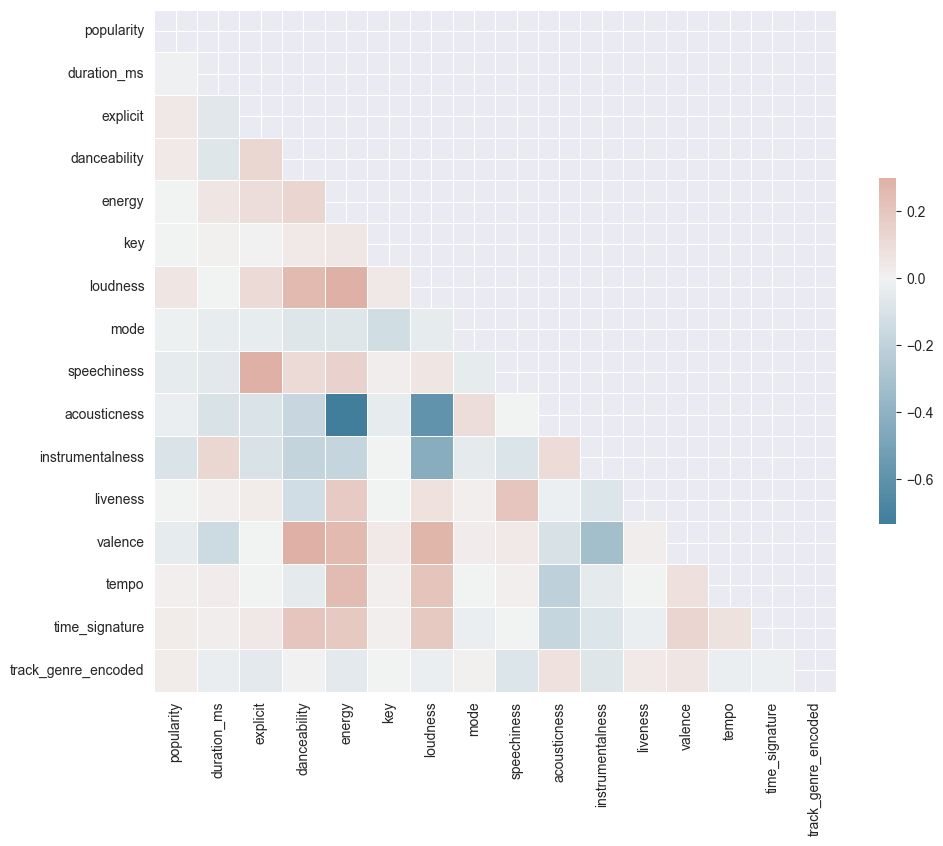

In [3]:
#Data importing 
dataFrame = pd.read_csv('./dataset.csv')

Cutoff = 40
Cutoffp = Cutoff / 100

# Label encoding 'track_genre'
le = LabelEncoder()
dataFrame['track_genre_encoded'] = le.fit_transform(dataFrame['track_genre'])

# Drop the columns
dataFrame = dataFrame.drop(
    columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre'])
# Calculate correlation matrix
corr_matrix = dataFrame.corr()

# Show correlation matrix
print(corr_matrix)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True, )

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [4]:

inputs = ['track_genre_encoded', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
          'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit']
target = ['popularity']
xtrain, xtest, ytrain, ytest = train_test_split(dataFrame[inputs], dataFrame[target], test_size=0.2, random_state=42)
# Assuming y_train is your training labels
positive_class_proportion = np.mean(ytrain)

print(f"The AUPRC baseline is: {positive_class_proportion}")

The AUPRC baseline is: 33.28171052631579


In [5]:
# fitting model
model = neighbors.KNeighborsRegressor(15)
model.fit(xtrain, ytrain)

# creating predictions
y_train_scores = model.predict(xtrain)
y_test_scores = model.predict(xtest)

# Apply same threshold to train predictions
y_train_pred = (y_train_scores > Cutoffp).astype(int)
y_test_pred = (y_test_scores > Cutoffp).astype(int)

ytrain = (ytrain > Cutoffp).astype(int)
ytest = (ytest > Cutoffp).astype(int)

# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(ytrain, y_train_pred)
precision_test, recall_test, _ = precision_recall_curve(ytest, y_test_pred)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}\n")

# Calculate F1 Score
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test} \n")

# Calculate accuracy, precision and recall for training set
accuracy_train = accuracy_score(ytrain, y_train_pred)
precision_train = precision_score(ytrain, y_train_pred, average='macro')
recall_train = recall_score(ytrain, y_train_pred, average='macro')

# Calculate accuracy, precision and recall for test set
accuracy_test = accuracy_score(ytest, y_test_pred)
precision_test = precision_score(ytest, y_test_pred, average='macro')
recall_test = recall_score(ytest, y_test_pred, average='macro')

print(f"Accuracy on Training set: {accuracy_train}")
print(f"Accuracy on Testing set: {accuracy_test}\n")

print(f"Recall on Training set: {recall_train}")
print(f"Recall on Testing set: {recall_test}\n")

print(f"Precision on Training set: {precision_train}")
print(f"Precision on Testing set: {precision_test}\n")

# Calculate confusion matrix for training set and test set
cm_train = confusion_matrix(ytrain, y_train_pred)
cm_test = confusion_matrix(ytest, y_test_pred)

print(f"Confusion Matrix on Training set: \n{cm_train}")
print(f"Confusion Matrix on Testing set: \n{cm_test}")

AUPRC on Training set: 0.9335131366015971
AUPRC on Testing set: 0.9327981192519184

F1 Score on Training set: 0.9284867594414546
F1 Score on Testing set: 0.9276351655644837 

Accuracy on Training set: 0.8676973684210526
Accuracy on Testing set: 0.8660964912280702

Recall on Training set: 0.5310160068720817
Recall on Testing set: 0.5273874078299454

Precision on Training set: 0.896215027657211
Precision on Testing set: 0.8871776151182482

Confusion Matrix on Training set: 
[[  805 12001]
 [   65 78329]]
Confusion Matrix on Testing set: 
[[  179  3035]
 [   18 19568]]


In [6]:

ytrain.loc[ytrain['popularity'] > Cutoff, 'popularity'] = 1
ytest.loc[ytest['popularity'] > Cutoff, 'popularity'] = 1

model = neighbors.KNeighborsClassifier(n_neighbors=4)
model.fit(xtrain, ytrain.values.ravel())

y_train_pred = model.predict(xtrain)
y_test_pred = model.predict(xtest)

# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(ytrain, y_train_pred)
precision_test, recall_test, _ = precision_recall_curve(ytest, y_test_pred)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}\n")

# Calculate F1 Score
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test} \n")

# Calculate accuracy, precision and recall for training set
accuracy_train = accuracy_score(ytrain, y_train_pred)
precision_train = precision_score(ytrain, y_train_pred, average='macro')
recall_train = recall_score(ytrain, y_train_pred, average='macro')

# Calculate accuracy, precision and recall for test set
accuracy_test = accuracy_score(ytest, y_test_pred)
precision_test = precision_score(ytest, y_test_pred, average='macro')
recall_test = recall_score(ytest, y_test_pred, average='macro')

print(f"Accuracy on Training set: {accuracy_train}")
print(f"Accuracy on Testing set: {accuracy_test}\n")

print(f"Recall on Training set: {recall_train}")
print(f"Recall on Testing set: {recall_test}\n")

print(f"Precision on Training set: {precision_train}")
print(f"Precision on Testing set: {precision_test}\n")

# Calculate confusion matrix for training set and test set
cm_train = confusion_matrix(ytrain, y_train_pred)
cm_test = confusion_matrix(ytest, y_test_pred)

print(f"Confusion Matrix on Training set: \n{cm_train}")
print(f"Confusion Matrix on Testing set: \n{cm_test}")

AUPRC on Training set: 0.9745017223166419
AUPRC on Testing set: 0.9545452896567993

F1 Score on Training set: 0.9455088426931431
F1 Score on Testing set: 0.910300895955254 

Accuracy on Training set: 0.9075657894736842
Accuracy on Testing set: 0.8480701754385965

Recall on Training set: 0.8425834079078147
Recall on Testing set: 0.7223599130501697

Precision on Training set: 0.8026819310685207
Precision on Testing set: 0.6951878565901747

Confusion Matrix on Training set: 
[[ 9633  3173]
 [ 5257 73137]]
Confusion Matrix on Testing set: 
[[ 1759  1455]
 [ 2009 17577]]


In [7]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(xtrain)
X_test = sc.transform(xtest)

# Training the SVM model on the Training set using a linear kernel
svm_classifier = SVC(kernel = 'rbf', random_state = 42)
svm_classifier.fit(xtrain, ytrain.values.ravel())

# Predicting the Test set results
y_pred = svm_classifier.predict(xtest)

# Evaluating the model
accuracy = accuracy_score(ytest, y_pred)
classification_report_results = classification_report(ytest, y_pred, target_names=['Not Popular', 'Popular'])

classification_report_results

/Users/benfunk/DataspellProjects/RandomProjects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/benfunk/DataspellProjects/RandomProjects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/benfunk/DataspellProjects/RandomProjects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

'              precision    recall  f1-score   support\n\n Not Popular       0.00      0.00      0.00      3214\n     Popular       0.86      1.00      0.92     19586\n\n    accuracy                           0.86     22800\n   macro avg       0.43      0.50      0.46     22800\nweighted avg       0.74      0.86      0.79     22800\n'

In [8]:
ypred_train = svm_classifier.predict(xtrain)
ypred_test = svm_classifier.predict(xtest)

cm_train = confusion_matrix(ytrain, ypred_train)
cm_test = confusion_matrix(ytest, ypred_test)

print(f"Confusion Matrix on Training set: \n{cm_train}")
print(f"Confusion Matrix on Testing set: \n{cm_test}")

Confusion Matrix on Training set: 
[[    0 12806]
 [    0 78394]]
Confusion Matrix on Testing set: 
[[    0  3214]
 [    0 19586]]


In [7]:
model = svm.SVC(kernel='rbf', C=1.0)
model.fit(xtrain, ytrain.values.ravel())

ypred_train = model.predict(xtrain)
ypred_train = (ypred_train > Cutoffp).astype(int)  # Apply a threshold

ypred_test = model.predict(xtest)
ypred_test = (ypred_test > Cutoffp).astype(int)  # Apply a threshold

# precision-recall curve
precision_train, recall_train, _ = precision_recall_curve(ytrain, ypred_train)
precision_test, recall_test, _ = precision_recall_curve(ytest, ypred_test)
# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}\n")

# Calculate F1 Score
f1_train = f1_score(ytrain, ypred_train)
f1_test = f1_score(ytest, ypred_test)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test} \n")

# Calculate accuracy, precision and recall for training set
accuracy_train = accuracy_score(ytrain, ypred_train)
precision_train = precision_score(ytrain, ypred_train, average='macro')
recall_train = recall_score(ytrain, ypred_train, average='macro')

# Calculate accuracy, precision and recall for test set
accuracy_test = accuracy_score(ytest, ypred_test)
precision_test = precision_score(ytest, ypred_test, average='macro')
recall_test = recall_score(ytest, ypred_test, average='macro')

print(f"\nAccuracy on Training set: {accuracy_train}")
print(f"Accuracy on Testing set: {accuracy_test}\n")

print(f"Recall on Training set: {recall_train}")
print(f"Recall on Testing set: {recall_test}\n")

print(f"Precision on Training set: {precision_train}")
print(f"Precision on Testing set: {precision_test}\n")

# Calculate confusion matrix for training set and test set
cm_train = confusion_matrix(ytrain, ypred_train)
cm_test = confusion_matrix(ytest, ypred_test)

print(f"Confusion Matrix on Training set: \n{cm_train}")
print(f"Confusion Matrix on Testing set: \n{cm_test}")

AUPRC on Training set: 0.7050822368421052
AUPRC on Testing set: 0.7032236842105263

F1 Score on Training set: 0.0
F1 Score on Testing set: 0.0 


Accuracy on Training set: 0.5898355263157895
Accuracy on Testing set: 0.5935526315789473

Recall on Training set: 0.5
Recall on Testing set: 0.5

Precision on Training set: 0.29491776315789475
Precision on Testing set: 0.29677631578947367

Confusion Matrix on Training set: 
[[53793     0]
 [37407     0]]
Confusion Matrix on Testing set: 
[[13533     0]
 [ 9267     0]]


/Users/benfunk/DataspellProjects/RandomProjects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/benfunk/DataspellProjects/RandomProjects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
model = svm.SVC(kernel='polynomial', C=1.0)
model.fit(xtrain, ytrain.values.ravel())

ypred_train = model.predict(xtrain)
ypred_train = (ypred_train > Cutoffp).astype(int)  # Apply a threshold

ypred_test = model.predict(xtest)
ypred_test = (ypred_test > Cutoffp).astype(int)  # Apply a threshold

# precision-recall curve
precision_train, recall_train, _ = precision_recall_curve(ytrain, ypred_train)
precision_test, recall_test, _ = precision_recall_curve(ytest, ypred_test)
# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}\n")

# Calculate F1 Score
f1_train = f1_score(ytrain, ypred_train)
f1_test = f1_score(ytest, ypred_test)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test} \n")

# Calculate accuracy, precision and recall for training set
accuracy_train = accuracy_score(ytrain, ypred_train)
precision_train = precision_score(ytrain, ypred_train, average='macro')
recall_train = recall_score(ytrain, ypred_train, average='macro')

# Calculate accuracy, precision and recall for test set
accuracy_test = accuracy_score(ytest, ypred_test)
precision_test = precision_score(ytest, ypred_test, average='macro')
recall_test = recall_score(ytest, ypred_test, average='macro')

print(f"\nAccuracy on Training set: {accuracy_train}")
print(f"Accuracy on Testing set: {accuracy_test}\n")

print(f"Recall on Training set: {recall_train}")
print(f"Recall on Testing set: {recall_test}\n")

print(f"Precision on Training set: {precision_train}")
print(f"Precision on Testing set: {precision_test}\n")

# Calculate confusion matrix for training set and test set
cm_train = confusion_matrix(ytrain, ypred_train)
cm_test = confusion_matrix(ytest, ypred_test)

print(f"Confusion Matrix on Training set: \n{cm_train}")
print(f"Confusion Matrix on Testing set: \n{cm_test}")

In [49]:

# Data importing
dataFrame = pd.read_csv('./dataset.csv')

# Label encoding 'track_genre'
le = LabelEncoder()
dataFrame['track_genre_encoded'] = le.fit_transform(dataFrame['track_genre'])

# Drop the columns
dataFrame = dataFrame.drop(
    columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre', 'popularity'])

# Split into features and target
X = dataFrame.drop(columns=['popularity_flag'])
y = dataFrame['popularity_flag']
# Handle missing values - filling with 0 as an example
X_filled = X.fillna(0)

# Optionally, convert to a specific dtype (e.g., float32) to ensure consistency
X_filled = X_filled.astype('float32')

In [50]:

# Now convert to PyTorch tensors
X_tensor = torch.tensor(X_filled.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(
    1)  # Assuming y is already numeric and has no missing values

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Use pin_memory=True safely because data is on CPU
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False, pin_memory=True)

In [51]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [52]:

# Model definition
class NeuralNetwork(nn.Module):
    def __init__(self, input_shape):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_shape, 8),
            nn.ReLU(),
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ELU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


# Loss Functions
def calculate_f1(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    true_y, pred_y = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            preds = torch.round(torch.sigmoid(logits))
            true_y.extend(y.view(-1).tolist())
            pred_y.extend(preds.view(-1).tolist())
    f1 = f1_score(true_y, pred_y)
    return f1


# Move the model to the specified device (GPU or CPU)
model = NeuralNetwork(X_tensor.shape[1]).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters())


# Training loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # Set the model to training mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)


# Initialize the model and optimizer
input_shape = X_tensor.shape[1]
model = NeuralNetwork(input_shape).to(device)
optimizer = torch.optim.Adam(model.parameters())

class_weights = torch.linspace(3.5, 3.7, 100).to(device)  # class weights

# Variables to save the best model
best_f1 = 0
best_model = None
best_pos_weight = None

for weight in tqdm(class_weights):
    pos_weight = torch.tensor([weight]).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Initialize model and optimizer for each run
    model = NeuralNetwork(input_shape).to(device)
    optimizer = torch.optim.Adam(model.parameters())

    # Train the model
    train_loop(train_loader, model, loss_fn, optimizer)

    # Evaluate F1 Score on the validation set
    f1 = calculate_f1(model, test_loader, device)

    if f1 > best_f1:
        best_f1 = f1
        best_pos_weight = weight
        # This is the key part - we save the model that has the highest F1 score
        best_model = model

print("Best class weight (pos_weight): ", best_pos_weight.item())
print("Best F1 score: ", best_f1)

100%|██████████| 100/100 [00:44<00:00,  2.22it/s]

Best class weight (pos_weight):  3.848484754562378
Best F1 score:  0.5826184259604625


In [53]:

# Put the best model in evaluation mode
best_model.eval()

# Lists for storing predicted and actual labels
pred_labels, true_labels = [], []

# Get the true and predicted labels
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Make predictions 
        y_pred_probs = best_model(X_batch)

        # Apply a threshold
        y_pred = (y_pred_probs > Cutoffp).type(torch.IntTensor)

        # Store the true and predicted labels
        pred_labels.extend(y_pred.reshape(-1).tolist())
        true_labels.extend(y_batch.reshape(-1).tolist())

# Convert the lists into NumPy arrays
true_labels_np = np.array(true_labels)
pred_labels_np = np.array(pred_labels)

# Calculate accuracy, precision and recall
accuracy = accuracy_score(true_labels_np, pred_labels_np)
precision = precision_score(true_labels_np, pred_labels_np, average='macro')
recall = recall_score(true_labels_np, pred_labels_np, average='macro')

print("\nAccuracy: {:.2f}".format(accuracy))
print("Recall: {:.2f}".format(recall))
print("Precision: {:.2f}\n".format(precision))

# Calculate confusion matrix
cm = confusion_matrix(true_labels_np, pred_labels_np)

print("Confusion Matrix: \n", cm)

# Calculate Precision-Recall curve
precision_curve, recall_curve, _ = precision_recall_curve(true_labels_np, pred_labels_np)

# Calculate AUC
auprc = auc(recall_curve, precision_curve)

print("\nAUPRC: {:.2f}".format(auprc))

# Calculate F1 Score
f1 = f1_score(true_labels_np, pred_labels_np)

print("F1 Score: {:.2f}\n".format(f1))


Accuracy: 0.41
Recall: 0.50
Precision: 0.21

Confusion Matrix: 
 [[    0 13428]
 [    0  9372]]

AUPRC: 0.71
F1 Score: 0.58


/Users/benfunk/DataspellProjects/RandomProjects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [54]:
# Convert to tensor
X_tensor = tf.convert_to_tensor(X.values, dtype=tf.float32)
y_tensor = tf.convert_to_tensor(y.values, dtype=tf.float32)

# Calculate the index at which to split the dataset
train_size = int(0.8 * len(X))

# Manually slice the tensors for train/test sets
x_train_tensor = X_tensor[:train_size]
y_train_tensor = y_tensor[:train_size]
x_test_tensor = X_tensor[train_size:]
y_test_tensor = y_tensor[train_size:]


@keras.saving.register_keras_serializable()
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))


@keras.saving.register_keras_serializable()
def rmse(y_true, y_pred):
    return tf.sqrt(mse_loss(y_true, y_pred))


@keras.saving.register_keras_serializable()
def r_squared(y_true, y_pred, ):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2


@keras.saving.register_keras_serializable()
def r_squared_loss(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return 1 - r2  # or you can return -r2 to minimize the negative value



def plot_results(history):
    epoch_num = np.arange(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_num, history.history['loss'], label='training_loss')
    plt.plot(epoch_num, history.history['val_loss'], label='test_loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epoch_num, history.history['accuracy'], label='training_accuracy')
    plt.plot(epoch_num, history.history['val_accuracy'], label='test_accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)


In [57]:

input_shape = (x_train_tensor.shape[1],)


# Build model function
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


# Define a set of class weights to evaluate
class_weights_grid = [{0: 1.0, 1: weight} for weight in
                      np.linspace(3.5, 3.7, 100)]  # Drop the 100 down to 10 if you are running this on a weaker computer.

# Initial placeholders for the best weights and highest f1 score
best_class_weights = None
highest_f1 = 0

In [58]:

for class_weights in tqdm(class_weights_grid):

    #Build and compile model as before
    model = build_model(input_shape)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[metrics.BinaryAccuracy(name='accuracy'),
                           metrics.Precision(name='precision'),
                           metrics.Recall(name='recall'),
                           metrics.AUC(name='auc')])

    # Train model with current class weight
    model.fit(x_train_tensor,
              y_train_tensor,
              epochs=20,
              validation_split=0.1,
              batch_size=200,
              class_weight=class_weights,
              verbose=0)  # Turn off output 

    # Evaluate F1 Score
    y_train_scores = model.predict(x_train_tensor).flatten()
    y_train_pred = (y_train_scores > Cutoffp).astype(int)
    f1 = f1_score(y_train_tensor, y_train_pred)

    if f1 > highest_f1:
        best_class_weights = class_weights
        highest_f1 = f1

# Output the best class weights
print("Best class weights: ", best_class_weights)
print("Best F1 score: ", highest_f1)

  0%|          | 0/100 [00:00<?, ?it/s]

2850/2850 [==============================] - 1s 220us/step


  1%|          | 1/100 [00:05<09:06,  5.52s/it]

2850/2850 [==============================] - 1s 212us/step


  2%|▏         | 2/100 [00:10<08:06,  4.97s/it]

2850/2850 [==============================] - 1s 214us/step


  3%|▎         | 3/100 [00:14<07:42,  4.77s/it]

2850/2850 [==============================] - 1s 220us/step


  4%|▍         | 4/100 [00:19<07:31,  4.70s/it]

2850/2850 [==============================] - 1s 213us/step


  5%|▌         | 5/100 [00:23<07:22,  4.66s/it]

2850/2850 [==============================] - 1s 214us/step


  6%|▌         | 6/100 [00:28<07:15,  4.63s/it]

2850/2850 [==============================] - 1s 214us/step


  7%|▋         | 7/100 [00:32<07:08,  4.61s/it]

2850/2850 [==============================] - 1s 213us/step


  8%|▊         | 8/100 [00:37<07:04,  4.61s/it]

2850/2850 [==============================] - 1s 216us/step


  9%|▉         | 9/100 [00:42<07:07,  4.70s/it]

2850/2850 [==============================] - 1s 215us/step


 10%|█         | 10/100 [00:47<07:01,  4.68s/it]

2850/2850 [==============================] - 1s 211us/step


 11%|█         | 11/100 [00:51<06:57,  4.70s/it]

2850/2850 [==============================] - 1s 214us/step


 12%|█▏        | 12/100 [00:56<06:48,  4.64s/it]

2850/2850 [==============================] - 1s 215us/step


 13%|█▎        | 13/100 [01:00<06:42,  4.62s/it]

2850/2850 [==============================] - 1s 211us/step


 14%|█▍        | 14/100 [01:05<06:35,  4.60s/it]

2850/2850 [==============================] - 1s 214us/step


 15%|█▌        | 15/100 [01:10<06:29,  4.58s/it]

2850/2850 [==============================] - 1s 215us/step


 16%|█▌        | 16/100 [01:14<06:24,  4.58s/it]

2850/2850 [==============================] - 1s 216us/step


 17%|█▋        | 17/100 [01:19<06:19,  4.57s/it]

2850/2850 [==============================] - 1s 214us/step


 18%|█▊        | 18/100 [01:23<06:13,  4.56s/it]

2850/2850 [==============================] - 1s 215us/step


 19%|█▉        | 19/100 [01:28<06:09,  4.56s/it]

2850/2850 [==============================] - 1s 213us/step


 20%|██        | 20/100 [01:32<06:04,  4.56s/it]

2850/2850 [==============================] - 1s 212us/step


 21%|██        | 21/100 [01:37<05:59,  4.56s/it]

2850/2850 [==============================] - 1s 212us/step


 22%|██▏       | 22/100 [01:41<05:55,  4.56s/it]

2850/2850 [==============================] - 1s 213us/step


 23%|██▎       | 23/100 [01:46<05:49,  4.54s/it]

2850/2850 [==============================] - 1s 218us/step


 24%|██▍       | 24/100 [01:50<05:45,  4.55s/it]

2850/2850 [==============================] - 1s 213us/step


 25%|██▌       | 25/100 [01:55<05:40,  4.54s/it]

2850/2850 [==============================] - 1s 303us/step


 26%|██▌       | 26/100 [02:00<05:42,  4.63s/it]

2850/2850 [==============================] - 1s 212us/step


 27%|██▋       | 27/100 [02:05<05:40,  4.66s/it]

2850/2850 [==============================] - 1s 214us/step


 28%|██▊       | 28/100 [02:09<05:33,  4.63s/it]

2850/2850 [==============================] - 1s 215us/step


 29%|██▉       | 29/100 [02:14<05:27,  4.62s/it]

2850/2850 [==============================] - 1s 215us/step


 30%|███       | 30/100 [02:18<05:22,  4.61s/it]

2850/2850 [==============================] - 1s 220us/step


 31%|███       | 31/100 [02:23<05:16,  4.59s/it]

2850/2850 [==============================] - 1s 221us/step


 32%|███▏      | 32/100 [02:27<05:11,  4.58s/it]

2850/2850 [==============================] - 1s 213us/step


 33%|███▎      | 33/100 [02:32<05:07,  4.58s/it]

2850/2850 [==============================] - 1s 218us/step


 34%|███▍      | 34/100 [02:37<05:01,  4.57s/it]

2850/2850 [==============================] - 1s 211us/step


 35%|███▌      | 35/100 [02:41<04:58,  4.59s/it]

2850/2850 [==============================] - 1s 214us/step


 36%|███▌      | 36/100 [02:46<04:53,  4.59s/it]

2850/2850 [==============================] - 1s 211us/step


 37%|███▋      | 37/100 [02:50<04:48,  4.58s/it]

2850/2850 [==============================] - 1s 220us/step


 38%|███▊      | 38/100 [02:55<04:47,  4.63s/it]

2850/2850 [==============================] - 1s 214us/step


 39%|███▉      | 39/100 [03:00<04:43,  4.65s/it]

2850/2850 [==============================] - 1s 216us/step


 40%|████      | 40/100 [03:05<04:41,  4.70s/it]

2850/2850 [==============================] - 1s 219us/step


 41%|████      | 41/100 [03:09<04:39,  4.73s/it]

2850/2850 [==============================] - 1s 223us/step


 42%|████▏     | 42/100 [03:14<04:36,  4.76s/it]

2850/2850 [==============================] - 1s 217us/step


 43%|████▎     | 43/100 [03:19<04:37,  4.87s/it]

2850/2850 [==============================] - 1s 216us/step


 44%|████▍     | 44/100 [03:26<05:08,  5.51s/it]

2850/2850 [==============================] - 1s 219us/step


 45%|████▌     | 45/100 [03:32<04:59,  5.45s/it]

2850/2850 [==============================] - 1s 224us/step


 46%|████▌     | 46/100 [03:37<04:45,  5.29s/it]

2850/2850 [==============================] - 1s 220us/step


 47%|████▋     | 47/100 [03:42<04:34,  5.19s/it]

2850/2850 [==============================] - 1s 227us/step


 48%|████▊     | 48/100 [03:47<04:42,  5.43s/it]

2850/2850 [==============================] - 1s 228us/step


 49%|████▉     | 49/100 [03:52<04:29,  5.28s/it]

2850/2850 [==============================] - 1s 218us/step


 50%|█████     | 50/100 [03:57<04:13,  5.07s/it]

2850/2850 [==============================] - 1s 216us/step


 51%|█████     | 51/100 [04:02<04:01,  4.92s/it]

2850/2850 [==============================] - 1s 215us/step


 52%|█████▏    | 52/100 [04:06<03:50,  4.81s/it]

2850/2850 [==============================] - 1s 215us/step


 53%|█████▎    | 53/100 [04:11<03:43,  4.75s/it]

2850/2850 [==============================] - 1s 216us/step


 54%|█████▍    | 54/100 [04:15<03:37,  4.72s/it]

2850/2850 [==============================] - 1s 212us/step


 55%|█████▌    | 55/100 [04:20<03:30,  4.69s/it]

2850/2850 [==============================] - 1s 211us/step


 56%|█████▌    | 56/100 [04:25<03:24,  4.66s/it]

2850/2850 [==============================] - 1s 215us/step


 57%|█████▋    | 57/100 [04:29<03:19,  4.63s/it]

2850/2850 [==============================] - 1s 212us/step


 58%|█████▊    | 58/100 [04:34<03:14,  4.62s/it]

2850/2850 [==============================] - 1s 216us/step


 59%|█████▉    | 59/100 [04:38<03:09,  4.62s/it]

2850/2850 [==============================] - 1s 219us/step


 60%|██████    | 60/100 [04:43<03:04,  4.62s/it]

2850/2850 [==============================] - 1s 214us/step


 61%|██████    | 61/100 [04:48<02:59,  4.61s/it]

2850/2850 [==============================] - 1s 216us/step


 62%|██████▏   | 62/100 [04:52<02:55,  4.61s/it]

2850/2850 [==============================] - 1s 216us/step


 63%|██████▎   | 63/100 [04:57<02:53,  4.69s/it]

2850/2850 [==============================] - 1s 213us/step


 64%|██████▍   | 64/100 [05:02<02:47,  4.64s/it]

2850/2850 [==============================] - 1s 213us/step


 65%|██████▌   | 65/100 [05:06<02:42,  4.63s/it]

2850/2850 [==============================] - 1s 211us/step


 66%|██████▌   | 66/100 [05:11<02:36,  4.60s/it]

2850/2850 [==============================] - 1s 221us/step


 67%|██████▋   | 67/100 [05:15<02:31,  4.60s/it]

2850/2850 [==============================] - 1s 211us/step


 68%|██████▊   | 68/100 [05:20<02:27,  4.60s/it]

2850/2850 [==============================] - 1s 215us/step


 69%|██████▉   | 69/100 [05:25<02:22,  4.60s/it]

2850/2850 [==============================] - 1s 210us/step


 70%|███████   | 70/100 [05:29<02:17,  4.59s/it]

2850/2850 [==============================] - 1s 213us/step


 71%|███████   | 71/100 [05:34<02:13,  4.60s/it]

2850/2850 [==============================] - 1s 216us/step


 72%|███████▏  | 72/100 [05:38<02:08,  4.60s/it]

2850/2850 [==============================] - 1s 212us/step


 73%|███████▎  | 73/100 [05:43<02:04,  4.61s/it]

2850/2850 [==============================] - 1s 215us/step


 74%|███████▍  | 74/100 [05:48<01:59,  4.60s/it]

2850/2850 [==============================] - 1s 215us/step


 75%|███████▌  | 75/100 [05:52<01:54,  4.60s/it]

2850/2850 [==============================] - 1s 217us/step


 76%|███████▌  | 76/100 [05:57<01:50,  4.60s/it]

2850/2850 [==============================] - 1s 215us/step


 77%|███████▋  | 77/100 [06:01<01:45,  4.60s/it]

2850/2850 [==============================] - 1s 216us/step


 78%|███████▊  | 78/100 [06:06<01:41,  4.60s/it]

2850/2850 [==============================] - 1s 215us/step


 79%|███████▉  | 79/100 [06:11<01:36,  4.60s/it]

2850/2850 [==============================] - 1s 215us/step


 80%|████████  | 80/100 [06:15<01:32,  4.62s/it]

2850/2850 [==============================] - 1s 215us/step


 81%|████████  | 81/100 [06:20<01:27,  4.61s/it]

2850/2850 [==============================] - 1s 213us/step


 82%|████████▏ | 82/100 [06:24<01:22,  4.59s/it]

2850/2850 [==============================] - 1s 212us/step


 83%|████████▎ | 83/100 [06:29<01:18,  4.59s/it]

2850/2850 [==============================] - 1s 215us/step


 84%|████████▍ | 84/100 [06:34<01:15,  4.70s/it]

2850/2850 [==============================] - 1s 220us/step


 85%|████████▌ | 85/100 [06:38<01:09,  4.66s/it]

2850/2850 [==============================] - 1s 213us/step


 86%|████████▌ | 86/100 [06:43<01:04,  4.63s/it]

2850/2850 [==============================] - 1s 211us/step


 87%|████████▋ | 87/100 [06:48<00:59,  4.61s/it]

2850/2850 [==============================] - 1s 213us/step


 88%|████████▊ | 88/100 [06:52<00:55,  4.59s/it]

2850/2850 [==============================] - 1s 214us/step


 89%|████████▉ | 89/100 [06:57<00:50,  4.59s/it]

2850/2850 [==============================] - 1s 214us/step


 90%|█████████ | 90/100 [07:01<00:45,  4.59s/it]

2850/2850 [==============================] - 1s 214us/step


 91%|█████████ | 91/100 [07:06<00:41,  4.60s/it]

2850/2850 [==============================] - 1s 219us/step


 92%|█████████▏| 92/100 [07:10<00:36,  4.59s/it]

2850/2850 [==============================] - 1s 213us/step


 93%|█████████▎| 93/100 [07:15<00:32,  4.59s/it]

2850/2850 [==============================] - 1s 213us/step


 94%|█████████▍| 94/100 [07:20<00:27,  4.59s/it]

2850/2850 [==============================] - 1s 216us/step


 95%|█████████▌| 95/100 [07:24<00:22,  4.59s/it]

2850/2850 [==============================] - 1s 251us/step


 96%|█████████▌| 96/100 [07:29<00:18,  4.62s/it]

2850/2850 [==============================] - 1s 213us/step


 97%|█████████▋| 97/100 [07:34<00:13,  4.61s/it]

2850/2850 [==============================] - 1s 211us/step


 98%|█████████▊| 98/100 [07:38<00:09,  4.59s/it]

2850/2850 [==============================] - 1s 222us/step


 99%|█████████▉| 99/100 [07:43<00:04,  4.58s/it]

2850/2850 [==============================] - 1s 215us/step


100%|██████████| 100/100 [07:47<00:00,  4.68s/it]

Best class weights:  {0: 1.0, 1: 2.8181818181818183}
Best F1 score:  0.5888932465291395


In [59]:


# Class weights for cost-sensitive training


class_weights = {0: 1., 1: 3.6}  # You can fine-tune this based on your specific case
early_stopping = EarlyStopping(monitor='accuracy', patience=50, restore_best_weights=True)

with tf.device('/GPU:0'):
    # Regular model training
    model = build_model(input_shape)
    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[metrics.BinaryAccuracy(name='accuracy'),
                           metrics.Precision(name='precision'),
                           metrics.Recall(name='recall'),
                           metrics.AUC(name='auc')])

    model.fit(x_train_tensor, y_train_tensor, epochs=20, validation_split=0.1, batch_size=200,
              class_weight=class_weights)

    # Get model's predictions (as class labels using threshold of 0.5)
    y_train_scores = model.predict(x_train_tensor).flatten()
    y_test_scores = model.predict(x_test_tensor).flatten()
    y_train_pred = (y_train_scores > Cutoffp).astype(int)
    y_test_pred = (y_test_scores > Cutoffp).astype(int)

    print(f"Summarizing model performance:\n")

    # Precision-Recall curve
    precision_train, recall_train, _ = precision_recall_curve(y_train_tensor, y_train_pred)
    precision_test, recall_test, _ = precision_recall_curve(y_test_tensor, y_test_pred)

    # Calculate AUC
    auprc_train = auc(recall_train, precision_train)
    auprc_test = auc(recall_test, precision_test)
    print(f"AUPRC on Training set: {auprc_train}")
    print(f"AUPRC on Testing set: {auprc_test}")

    # Calculate F1 Score
    f1_train = f1_score(y_train_tensor, y_train_pred)
    f1_test = f1_score(y_test_tensor, y_test_pred)
    print(f"F1 Score on Training set: {f1_train}")
    print(f"F1 Score on Testing set: {f1_test}")
    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.fit(x_train_tensor, y_train_tensor, epochs=20, validation_split=0.1, batch_size=200)  #Data importing
dataFrame = pd.read_csv('./dataset.csv')

# variable I will try to predict: popularity
# the dataset is taken from: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/

dataFrame['popularity_flag'] = 0
dataFrame.loc[dataFrame['popularity'] > Cutoff, 'popularity_flag'] = 1
# Label encoding 'track_genre'
le = LabelEncoder()
dataFrame['track_genre_encoded'] = le.fit_transform(dataFrame['track_genre'])

# Drop the columns
dataFrame = dataFrame.drop(
    columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre', 'popularity'])

inputs = ['track_genre_encoded', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
          'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit']
target = ['popularity_flag']

X_train, X_test, y_train, y_test = train_test_split(dataFrame[inputs], dataFrame[target], test_size=0.2,
                                                    random_state=42)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Print the confusion matrix using Matplotlib
y_train_scores_dt = dt.predict_proba(X_train)[:, 1]
y_test_scores_dt = dt.predict_proba(X_test)[:, 1]
# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores_dt)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores_dt)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")

# Calculate F1 Score for both train and test sets
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test}")

#Create a Gaussian Classifier
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train, y_train.values.ravel())
y_train_predrf = rf.predict(X_train)
y_test_predrf = rf.predict(X_test)

conf_matrix_rf = confusion_matrix(y_true=y_test, y_pred=y_test_predrf)

y_train_scores_dt = rf.predict_proba(X_train)[:, 1]
y_test_scores_dt = rf.predict_proba(X_test)[:, 1]
# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores_dt)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores_dt)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")

# Calculate F1 Score for both train and test sets
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test}")


def custom_auc(y_true, y_pred):
    # check if y_pred is 1-dimensional
    if len(y_pred.shape) == 1:
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
    else:
        precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 1])
    return auc(recall, precision)


# Create the parameter grid based on the results of random search
param_grid = {
    'max_depth': [20, 80, 100],
    'max_features': ['sqrt'],
    'n_estimators': [100, 500, 1000]
}
# Create a based model
rf_0 = RandomForestClassifier(n_jobs=-1, random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_0, param_grid=param_grid, scoring=make_scorer(custom_auc, needs_proba=True))
grid_search.fit(X_train, y_train.values.ravel())
print('Best Parameters: ', grid_search.best_params_, ' \n')

#Create a Gaussian Classifier
rf2 = RandomForestClassifier(n_estimators=1000, max_depth=100, max_features='sqrt', min_samples_leaf=1,
                             min_samples_split=2, n_jobs=-1, random_state=42)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf2.fit(X_train, y_train.values.ravel())

y_train_scores_dt = rf2.predict_proba(X_train)[:, 1]
y_test_scores_dt = rf2.predict_proba(X_test)[:, 1]

# Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores_dt)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores_dt)

# AUC
auprc_train = auc(recall_train, precision_train)
auprc_test = auc(recall_test, precision_test)

print(f"AUPRC on Training set: {auprc_train}")
print(f"AUPRC on Testing set: {auprc_test}")

# Calculate F1 Score for both train and test sets
f1_train = f1_score(ytrain, y_train_pred)
f1_test = f1_score(ytest, y_test_pred)

print(f"F1 Score on Training set: {f1_train}")
print(f"F1 Score on Testing set: {f1_test}")

Epoch 1/20
411/411 [==============================] - 1s 714us/step - loss: 1.2365 - accuracy: 0.4121 - precision: 0.4121 - recall: 1.0000 - auc: 0.4989 - val_loss: 0.8564 - val_accuracy: 0.4319 - val_precision: 0.4319 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/20
411/411 [==============================] - 0s 488us/step - loss: 1.2358 - accuracy: 0.4121 - precision: 0.4121 - recall: 1.0000 - auc: 0.4971 - val_loss: 0.8664 - val_accuracy: 0.4319 - val_precision: 0.4319 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/20
411/411 [==============================] - 0s 483us/step - loss: 1.2358 - accuracy: 0.4121 - precision: 0.4121 - recall: 1.0000 - auc: 0.4983 - val_loss: 0.8618 - val_accuracy: 0.4319 - val_precision: 0.4319 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 4/20
411/411 [==============================] - 0s 511us/step - loss: 1.2358 - accuracy: 0.4121 - precision: 0.4121 - recall: 1.0000 - auc: 0.4994 - val_loss: 0.8615 - val_accuracy: 0.4319 - val_precision: 0.4319 - val_r

/Users/benfunk/DataspellProjects/RandomProjects/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best Parameters:  {'max_depth': 80, 'max_features': 'sqrt', 'n_estimators': 1000}  
AUPRC on Training set: 0.9991328362200963
AUPRC on Testing set: 0.843844192752115
F1 Score on Training set: 0.5817302458672223
F1 Score on Testing set: 0.5779773599027037
